In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import norm
import pandas as pd
import itertools
from scipy.stats import dirichlet

In [2]:
def EstimateParameters(fixture_list_1, fixture_list_2, fixture_list_3,
                       teams, beta, thetapriormeans, thetapriorsds,
                       niter=1000, log=False, temp=0):
    
    # xdata and ydata are coordinates and y values of data
    # xmodel are coordinates of model evaluations
    # thetaprior are prior guesses for parameters
    
    # draw initial
    if log:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.exp(np.random.normal(thetapriormeans[i], thetapriorsds[i], 1))
        else:
            theta = np.exp(np.random.normal(thetapriormeans, thetapriorsds, 1))
    else:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.random.normal(thetapriormeans[i], thetapriorsds[i], 1)
            # normalize
            #theta[(len(teams) + 1 - 1)] = -np.sum(theta[1:(len(teams) + 1 - 1)])
            #theta[((2 * len(teams)) + 1 - 1)] = -np.sum(theta[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
        else:
            theta = np.random.normal(thetapriormeans, thetapriorsds, 1)
    
    if hasattr(thetapriormeans, '__len__'):
        thetaarray = np.zeros((niter, len(thetapriormeans)))
    else:
        thetaarray = np.zeros(niter)
    
    for j in range(niter):
        
        # temperature
        T = np.exp(-temp * ((i + 1) / niter))
        
        if log:
            if hasattr(thetapriormeans, '__len__'):
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), len(theta)))
            else:
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), 1))
        else:
            if hasattr(thetapriormeans, '__len__'):
                ind = np.random.normal(0, np.sqrt(beta), len(theta))
                # normalize
                #ind[(len(teams) + 1 - 1)] = -np.sum(ind[1:(len(teams) + 1 - 1)])
                #ind[((2 * len(teams)) + 1 - 1)] = -np.sum(ind[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
                thetastar = theta + ind
            else:
                ind = np.random.normal(0, np.sqrt(beta), 1)
                thetastar = theta + ind
        
        # get likelihood for each
        mu = theta[0]
        a = theta[1:(len(teams) + 1)]
        d = theta[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = theta[((2 * len(teams)) + 1)]
        Htheta = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                          teams, mu, a, d, alpha)
        
        mu = thetastar[0]
        a = thetastar[1:(len(teams) + 1)]
        d = thetastar[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = thetastar[((2 * len(teams)) + 1)]
        Hthetastar = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                              teams, mu, a, d, alpha)
        
        alpha = np.min([0, (1 / T) * (Hthetastar - Htheta)])
        
        # sample uniformly
        u = np.random.uniform(0, 1)
        
        # accept or not
        accept = np.log(u) <= alpha
        
        if accept:
            theta = thetastar
            
        if hasattr(thetapriormeans, '__len__'):
            thetaarray[j, :] = theta
            if (j%10) == 0:
                print('------')
                print('Iteration: ', str(j))
                print('Home coefficient: '+str(thetaarray[j, 0]))
                print('Arsenal attack coefficient: '+str(thetaarray[j, 1]))
        else:
            thetaarray[j] = theta
    
    return thetaarray

# create likelihood eval for one game
def likelihood_one_game(goals_ht, goals_at, form_ht, form_at, mu, a_ht, d_ht, a_at, d_at, alpha):
    lambda_ht = np.exp(mu + a_ht + d_at + (alpha * form_ht))
    lambda_at = np.exp(a_at + d_ht + (alpha * form_at))
    p1 = poisson.pmf(goals_ht, lambda_ht)
    p2 = poisson.pmf(goals_at, lambda_at)
    return(p1 * p2)

# create form matrix
def find_form(fixtures_list):
    
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    mat_form = np.zeros((N, 2))
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        mat_form[i, 0] = form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht]
        mat_form[i, 1] = form[team_count[ind_for_season_at].astype(int), ind_for_season_at]
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    
    return(teams_for_season, mat_form)

# create likelihood eval for single season
def likelihood_season(fixtures_list, teams, mu, a, d, alpha):
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    likelihood = np.zeros(N)
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        l = likelihood_one_game(goals_ht[i], goals_at[i],
                                form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht].astype(int), form[team_count[ind_for_season_at].astype(int), ind_for_season_at],
                                mu, a[ind_ht], d[ind_ht], a[ind_at], d[ind_at], alpha)
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
        likelihood[i] = l
    
    return(np.sum(np.log(likelihood)))

# likelihood over three seasons - weighted
def likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3, teams, mu, a, d, alpha):
    likelihood = (0.2 * likelihood_season(fixture_list_1, teams, mu, a, d, alpha)) + (0.3 * likelihood_season(fixture_list_2, teams, mu, a, d, alpha)) + (0.5 * likelihood_season(fixture_list_3, teams, mu, a, d, alpha))
    return(likelihood)

# function to predict probabilities of fixtures
def predict_fixtures(new_fixtures, form, teams, mu, a, d, alpha, uncertainty=False):
    if uncertainty:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            muest = np.random.normal(mu[0], mu[1])
            aest = np.zeros(len(teams))
            dest = np.zeros(len(teams))
            for u in range(len(teams)):
                aest[u] = np.random.normal(a[u, 0], a[u, 1])
                dest[u] = np.random.normal(d[u, 0], d[u, 1])
            alphaest = np.random.normal(alpha[0], alpha[1])
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(muest + aest[ind_ht] + dest[ind_at] + (alphaest * form[i, 0]))
            lambda_2[i] = np.exp(aest[ind_at] + dest[ind_ht] + (alphaest * form[i, 1]))
    else:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(mu + a[ind_ht] + d[ind_at] + (alpha * form[i, 0]))
            lambda_2[i] = np.exp(a[ind_at] + d[ind_ht] + (alpha * form[i, 1]))
    return(lambda_1, lambda_2)

def import_fixture_lists(filename_1, filename_2, filename_3):
    fixture_list_1 = pd.read_csv(filename_1, header=None)
    fixture_list_2 = pd.read_csv(filename_2, header=None)
    fixture_list_3 = pd.read_csv(filename_3, header=None)
    return(fixture_list_1, fixture_list_2, fixture_list_3)

### Optimization of players

#### Probability functions of points scoring

In [51]:
def sample_clean_sheet_for_team(lambda_2):
    return(np.random.poisson(lambda_2) == 0)

def sample_mins_played(a, b, a_games, b_games):
    return(np.random.choice([1, 0], 1, p=np.random.dirichlet([a_games, b_games]))[0] * np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))

def sample_goals_and_assists(a, b, c, n, mins_played):
    t_goals = np.random.uniform(0, 90, n)  # times of goals
    n_goals = np.sum(t_goals <= mins_played)
    d = np.random.dirichlet(np.array([a, b, c]))  # sample hyperparameters
    if (n_goals > 0):
        samples = np.random.choice(np.array([0, 1, 2]), n_goals, p=d)
        return(sum(samples == 0), sum(samples == 1))
    else:
        return(0, 0)

def sample_clean_sheet_points(goals_conceded, mins_played):
    return(int(mins_played > 60) * int(goals_conceded == 0))

def sample_mins_points(mins_played):
    return(int(mins_played > 60) + int(mins_played >= 1))

In [52]:
def get_players(all_players_params, team_sel):
    ind = all_players_params.index[all_players_params['team'] == team_sel]
    return(ind)

In [53]:
def ComputeExpectedPoints(fixtures_list, teams, all_players_params, all_teams_params,
                          zerooutbottom=0, Niter=250, additionalstats=False, form=None):
    
    # param data sets are pd Data Frames
    
    # Without bonus for now and goals conceded points
    
    # preallocate points for each iteration
    points = np.zeros((Niter, len(all_players_params.index)))
    clean_sheets = np.zeros((Niter, len(all_players_params.index)))
    goals_scored = np.zeros((Niter, len(all_players_params.index)))
    mplayed = np.zeros((Niter, len(all_players_params.index)))

    # mean and std of team hyperparameters
    mu = (all_teams_params.as_matrix())[0, :]
    a = (all_teams_params.as_matrix())[1:(len(teams) + 1), :]
    d = (all_teams_params.as_matrix())[(len(teams) + 1):((2 * len(teams)) + 1), :]
    alpha = (all_teams_params.as_matrix())[((2 * len(teams)) + 1), :]

    for l in range(Niter):
        
        # preallocate form array
        team_points = np.zeros((38, len(teams)))
        team_counter = np.zeros(len(teams))
        
        for i in range(np.shape(fixtures_list)[0]):
            
            # find teams for each fixture
            h_team = fixtures_list[i, 0]
            a_team = fixtures_list[i, 1]
            
            # compute form
            if hasattr(form, '__len__'):
                form_h = form[i, 0]
                form_a = form[i, 1]
            else:
                if team_counter[np.where(h_team == teams)[0][0]] > 5:
                    form_h = (np.cumsum(team_points[:, int(np.where(h_team == teams)[0][0])])[5:] - np.cumsum(team_points[:, int(np.where(h_team == teams)[0][0])])[:(38 - 5)])[int(team_counter[np.where(h_team == teams)[0][0]] - 1 - 5)]
                else:
                    form_h = 7.5
                if team_counter[np.where(a_team == teams)[0][0]] > 5:
                    form_a = (np.cumsum(team_points[:, int(np.where(a_team == teams)[0][0])])[5:] - np.cumsum(team_points[:, int(np.where(a_team == teams)[0][0])])[:(38 - 5)])[int(team_counter[np.where(a_team == teams)[0][0]] - 1 - 5)]
                else:
                    form_a = 7.5
            
            # sample lambdas for team performance - sample from team hyperparameters
            lambdas = predict_fixtures(np.reshape(fixtures_list[i, :2], ((1, 2))),
                                       np.reshape(np.array([form_h, form_a]), ((1, 2))),
                                       teams, mu, a, d, alpha, uncertainty=True)
            
            # sample score
            h_n = np.random.poisson(lambdas[0][0])
            a_n = np.random.poisson(lambdas[1][0])
            
            # compute incremental team points
            team_points[int(team_counter[np.where(h_team == teams)[0][0]]),
                        int(np.where(h_team == teams)[0][0])] += (3 * (h_n > a_n)) + (h_n == a_n)
            team_points[int(team_counter[np.where(a_team == teams)[0][0]]),
                        int(np.where(a_team == teams)[0][0])] += (3 * (h_n < a_n)) + (h_n == a_n)
            
            team_counter[np.where(h_team == teams)[0][0]] += 1
            team_counter[np.where(a_team == teams)[0][0]] += 1
            
            # find all players in these teams
            h_players = get_players(all_players_params, h_team)
            a_players = get_players(all_players_params, a_team)
            
            # loop over players
            for j in range(len(h_players)):
                
                # predefine scalings for points
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                
                # sample mins played
                mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[h_players[j]], 'a_mins'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'b_mins'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'a_games'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'b_games'])
                
                goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[h_players[j]], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[h_players[j]], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[h_players[j]], 'c_goals'],
                                                         h_n, mins_played)
                points[l, h_players[j]] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                csp = sample_clean_sheet_points(a_n, mins_played)
                points[l, h_players[j]] += ((scaling[2] * csp) +
                                            (sample_mins_points(mins_played)))
                clean_sheets[l, h_players[j]] += csp
                goals_scored[l, h_players[j]] += goa
                mplayed[l, h_players[j]] += mins_played
            
            for j in range(len(a_players)):
                
                # predefine scalings for points
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                
                # sample mins played
                mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[a_players[j]], 'a_mins'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'b_mins'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'a_games'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'b_games'])
                
                goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[a_players[j]], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[a_players[j]], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[a_players[j]], 'c_goals'],
                                                         a_n, mins_played)
                points[l, a_players[j]] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                csp = sample_clean_sheet_points(h_n, mins_played)
                points[l, a_players[j]] += ((scaling[2] * csp) +
                                            (sample_mins_points(mins_played)))
                clean_sheets[l, a_players[j]] += csp
                goals_scored[l, a_players[j]] += goa
                mplayed[l, a_players[j]] += mins_played

        print('---')
        print('Realisation ', l)
        print('Top Points Scorers: ', all_players_params.loc[all_players_params.index[np.argsort(points[l, :])[-5:].astype(int)], 'player'],
              ' with ', np.sort(points[l, :])[-5:], ' points')

    if zerooutbottom > 0:
        for l in range(Niter):
            points[l, np.argsort(points[l, :])[:zerooutbottom]] = 0  # to account for bench players when simulating team performance

    expected_points = np.mean(points, axis=0)
    sd_points = np.std(points, axis=0)
    cs = np.mean(clean_sheets, axis=0)
    gs = np.mean(goals_scored, axis=0)
    mp = np.mean(mplayed, axis=0)

    if additionalstats:
        return(expected_points, sd_points, cs, gs, mp)
    else:
        return(expected_points, sd_points)

### Historical fitting

In [54]:
form = np.ones((380, 2)) * 7.5

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

In [55]:
# create fixture list this season to predict
fixture_list_this_season = []
for i, fix in enumerate(list(itertools.permutations(((pd.read_csv("../data/team_id_20192020.csv", header=0)).as_matrix())[:, 0], 2))):
    fixture_list_this_season.append(list(fix))
fixture_list_this_season = np.array(fixture_list_this_season)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
# small fixture list - use for optimization for any particular gameweek
#fixture_list_this_season = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_season)

#type in current form here
#form=....

In [57]:
C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_this_season, teams, all_players_params, all_teams_params, Niter=50,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


---
Realisation  0
Top Points Scorers:  175             Luka Milivojevic
134                  Eden Hazard
322    Ederson Santana de Moraes
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [161. 162. 170. 192. 206.]  points
---
Realisation  1
Top Points Scorers:  372       Paul Pogba
130    Marcos Alonso
828     Matt Doherty
134      Eden Hazard
310    Mohamed Salah
Name: player, dtype: object  with  [167. 169. 171. 184. 244.]  points
---
Realisation  2
Top Points Scorers:  315      Virgil van Dijk
329      Raheem Sterling
516    Christian Eriksen
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [165. 170. 171. 186. 196.]  points
---
Realisation  3
Top Points Scorers:  764     James Maddison
329    Raheem Sterling
306         Sadio Mané
276        Jamie Vardy
310      Mohamed Salah
Name: player, dtype: object  with  [173. 183. 188. 191. 226.]  points
---
Realisation  4
Top Points Scorers:  322    Ede

---
Realisation  34
Top Points Scorers:  130      Marcos Alonso
306         Sadio Mané
826         Willy Boly
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [169. 171. 172. 202. 226.]  points
---
Realisation  35
Top Points Scorers:  306           Sadio Mané
329      Raheem Sterling
128    César Azpilicueta
522           Harry Kane
310        Mohamed Salah
Name: player, dtype: object  with  [160. 174. 175. 183. 216.]  points
---
Realisation  36
Top Points Scorers:  128    César Azpilicueta
341          Kyle Walker
130        Marcos Alonso
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [172. 177. 192. 192. 227.]  points
---
Realisation  37
Top Points Scorers:  315    Virgil van Dijk
372         Paul Pogba
306         Sadio Mané
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [172. 176. 200. 201. 227.]  points
---
Realisation  38
Top Points Scorers:  322    Ederson Santana de Moraes
30

In [58]:
# add expected points and std to data frame
all_players_params['Expected Points 2019/2020'] = C
all_players_params['Std Points 2019/2020'] = S
all_players_params['Lower 95% Confidence Points 2019/2020'] = np.fmax(0, C - (2 * S))
all_players_params['Upper 95% Confidence Points 2019/2020'] = C + (2 * S)
all_players_params['Expected Goals 2019/2020'] = G
all_players_params['Expected Clean Sheets 2019/2020'] = CS
all_players_params['Expected Minutes Played 2019/2020'] = MP

In [59]:
# save to csv
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frameref = frame[['player', 'position', 'team', 'Expected Points 2019/2020',
                  'Std Points 2019/2020', 'Lower 95% Confidence Points 2019/2020',
                  'Upper 95% Confidence Points 2019/2020', 'Expected Goals 2019/2020', 'Expected Clean Sheets 2019/2020',
                  'Expected Minutes Played 2019/2020']]
frameref.to_csv("../data/pre_draft_expected_points_20192020.csv")

In [60]:
# extract best current players
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,38.7,3,Mohamed Salah,MID,Liverpool,226.62,27.177115,172.265769,280.974231,21.50,15.60,2806.72
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,43.4,3,Raheem Sterling,MID,Man City,177.24,25.715801,125.808399,228.671601,13.46,13.86,2363.32
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,43.7,3,Sadio Mané,MID,Liverpool,160.52,23.433514,113.652971,207.387029,14.22,13.20,2439.12
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,28.0,3,Eden Hazard,MID,Chelsea,159.10,20.640010,117.819981,200.380019,11.32,10.72,2439.52
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,48.8,3,César Azpilicueta,DEF,Chelsea,153.20,15.565346,122.069308,184.330692,1.94,13.16,2968.66
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,22.5,3,Matt Doherty,DEF,Wolves,151.94,18.534735,114.870530,189.009470,3.64,10.70,2670.16
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,60.5,3,Virgil van Dijk,DEF,Liverpool,150.28,21.587070,107.105860,193.454140,3.38,14.04,2612.20
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,35.9,3,Christian Eriksen,MID,Tottenham,150.28,16.156782,117.966436,182.593564,8.06,12.68,2620.98
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,39.1,3,Marcos Alonso,DEF,Chelsea,149.24,19.958517,109.322966,189.157034,4.06,11.28,2515.44
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,146.88,10.640752,125.598496,168.161504,0.46,17.08,2972.18


In [61]:
# extract best current goalkeepers
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'GKP'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,146.88,10.640752,125.598496,168.161504,0.46,17.08,2972.18
772,772,20.5,1.0,1755.0,0.5,1.0,22.5,94.5,3,Alisson Ramses Becker,GKP,Liverpool,141.26,12.607633,116.044735,166.475265,0.60,15.64,2873.42
775,775,20.0,1.0,1755.0,1.0,1.0,22.0,82.5,3,David de Gea,GKP,Man United,124.86,11.949912,100.960176,148.759824,0.48,12.00,2881.16
710,710,19.5,1.0,1665.0,1.5,1.0,21.5,80.0,3,Kepa Arrizabalaga,GKP,Chelsea,124.40,12.633289,99.133421,149.666579,0.56,12.42,2699.04
506,506,28.3,1.0,2502.0,4.1,1.0,30.3,99.1,3,Hugo Lloris,GKP,Tottenham,120.34,15.904226,88.531548,152.148452,0.46,12.62,2681.78
196,196,32.2,1.0,2781.0,0.2,1.0,34.2,90.7,3,Jordan Pickford,GKP,Everton,118.46,13.494013,91.471973,145.448027,0.54,9.66,3042.38
844,844,19.5,1.0,1710.0,1.5,1.0,21.5,72.5,3,Rui Pedro dos Santos Patrício,GKP,Wolves,118.38,12.760705,92.858589,143.901411,0.62,10.86,2770.74
259,259,30.2,1.0,2644.5,2.2,1.0,32.2,87.8,3,Kasper Schmeichel,GKP,Leicester,106.88,11.902336,83.075328,130.684672,0.50,8.20,2855.86
474,474,31.7,1.0,2781.0,0.7,1.0,33.7,85.1,3,Lukasz Fabianski,GKP,West Ham,105.76,10.074840,85.610320,125.909680,0.36,7.02,3028.76
578,578,31.4,1.0,2754.0,1.0,1.0,33.4,85.4,3,Ben Foster,GKP,Watford,105.52,14.721739,76.076522,134.963478,0.40,7.20,2976.14


In [62]:
# extract best current defenders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'DEF'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,48.8,3,César Azpilicueta,DEF,Chelsea,153.20,15.565346,122.069308,184.330692,1.94,13.16,2968.66
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,22.5,3,Matt Doherty,DEF,Wolves,151.94,18.534735,114.870530,189.009470,3.64,10.70,2670.16
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,60.5,3,Virgil van Dijk,DEF,Liverpool,150.28,21.587070,107.105860,193.454140,3.38,14.04,2612.20
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,39.1,3,Marcos Alonso,DEF,Chelsea,149.24,19.958517,109.322966,189.157034,4.06,11.28,2515.44
316,316,26.4,1.3,2235.0,6.0,8.5,28.4,53.9,3,Andrew Robertson,DEF,Liverpool,144.10,16.606324,110.887352,177.312648,1.34,13.06,2441.90
341,341,27.9,1.5,2268.2,4.5,3.3,29.9,70.2,3,Kyle Walker,DEF,Man City,140.38,18.862545,102.654910,178.105090,1.54,14.66,2472.16
826,826,19.5,3.0,1629.0,1.5,1.0,21.5,25.5,3,Willy Boly,DEF,Wolves,139.34,16.778093,105.783814,172.896186,4.10,10.64,2648.54
721,721,19.0,3.0,1527.0,2.0,3.5,21.0,26.0,3,Lucas Digne,DEF,Everton,133.16,19.382838,94.394324,171.925676,3.74,8.36,2511.58
763,763,18.5,2.0,1606.5,2.5,5.0,20.5,22.5,3,Ricardo Domingos Barbosa Pereira,DEF,Leicester,132.98,19.109673,94.760654,171.199346,2.68,7.84,2608.68
833,833,20.0,1.0,1755.0,1.0,1.0,22.0,28.0,3,Conor Coady,DEF,Wolves,127.24,16.040648,95.158703,159.321297,1.46,10.96,2839.04


In [63]:
# extract best current midfielders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'MID'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,38.7,3,Mohamed Salah,MID,Liverpool,226.62,27.177115,172.265769,280.974231,21.50,15.60,2806.72
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,43.4,3,Raheem Sterling,MID,Man City,177.24,25.715801,125.808399,228.671601,13.46,13.86,2363.32
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,43.7,3,Sadio Mané,MID,Liverpool,160.52,23.433514,113.652971,207.387029,14.22,13.20,2439.12
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,28.0,3,Eden Hazard,MID,Chelsea,159.10,20.640010,117.819981,200.380019,11.32,10.72,2439.52
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,35.9,3,Christian Eriksen,MID,Tottenham,150.28,16.156782,117.966436,182.593564,8.06,12.68,2620.98
175,175,30.8,10.0,2678.7,1.6,2.6,32.8,27.0,3,Luka Milivojevic,MID,Crystal Palace,142.82,16.611671,109.596659,176.043341,10.98,7.88,2927.12
372,372,27.4,9.3,2192.0,5.0,9.9,29.4,31.0,3,Paul Pogba,MID,Man United,136.88,20.456432,95.967136,177.792864,7.54,10.48,2416.68
220,220,28.1,8.7,2283.1,4.3,5.2,30.1,24.6,3,Gylfi Sigurdsson,MID,Everton,130.70,20.632256,89.435487,171.964513,8.58,8.40,2502.68
817,817,19.5,5.5,1567.5,1.5,4.0,21.5,18.5,3,Felipe Anderson Pereira Gomes,MID,West Ham,128.22,15.532276,97.155448,159.284552,7.30,6.36,2591.86
563,563,29.9,9.0,2221.1,2.5,4.9,31.9,26.2,3,Richarlison de Andrade,MID,Everton,126.34,17.691365,90.957270,161.722730,8.34,8.00,2424.30


In [64]:
# extract best current forwards
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'FWD'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
522,522,26.6,18.2,2178.7,5.8,4.6,28.6,26.4,3,Harry Kane,FWD,Tottenham,145.62,22.380250,100.859500,190.380500,18.14,11.06,2345.80
276,276,29.9,16.0,2382.4,2.5,4.1,31.9,20.7,3,Jamie Vardy,FWD,Leicester,140.00,18.568791,102.862418,177.137582,14.82,7.64,2612.58
840,840,20.0,7.5,1601.0,1.0,6.0,22.0,12.5,3,Raúl Jiménez,FWD,Wolves,134.86,14.542366,105.775269,163.944731,10.38,10.66,2631.22
339,339,25.0,17.8,1861.5,7.4,8.3,27.0,37.3,3,Sergio Agüero,FWD,Man City,133.46,17.747349,97.965302,168.954698,14.80,11.54,1999.16
169,169,27.2,8.7,2328.2,5.2,8.6,29.2,18.4,3,Wilfried Zaha,FWD,Crystal Palace,127.80,16.920993,93.958014,161.641986,9.28,6.94,2523.72
311,311,29.6,11.5,2176.0,2.8,7.4,31.6,47.5,3,Roberto Firmino,FWD,Liverpool,126.86,15.908501,95.042998,158.677002,10.46,12.54,2387.90
31,31,22.9,15.0,1722.8,9.5,5.7,24.9,21.9,3,Pierre-Emerick Aubameyang,FWD,Arsenal,118.60,19.429874,79.740252,157.459748,13.24,6.26,1862.84
22,22,28.9,11.7,1952.6,3.5,8.5,30.9,32.3,3,Alexandre Lacazette,FWD,Arsenal,114.68,15.767612,83.144775,146.215225,9.68,5.56,2142.20
592,592,28.3,8.6,2175.0,4.1,5.9,30.3,16.1,3,Salomón Rondón,FWD,Newcastle,109.12,16.477427,76.165146,142.074854,7.50,9.04,2390.70
375,375,27.2,11.8,1967.8,5.2,3.6,29.2,34.9,3,Romelu Lukaku,FWD,Man United,106.66,14.174075,78.311850,135.008150,10.02,8.60,2157.36


### Analysis of previous season - model verification

In [65]:
# create fixture list this season to predict
fixture_list_last_season = pd.read_csv("../data/prem_results_20182019.csv", header=None).as_matrix()

teams_this_season, form = find_form(fixture_list_last_season)

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_last_season, teams, all_players_params, all_teams_params, Niter=50,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed i

---
Realisation  0
Top Points Scorers:  322    Ederson Santana de Moraes
339                Sergio Agüero
306                   Sadio Mané
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [168. 180. 185. 201. 235.]  points
---
Realisation  1
Top Points Scorers:  276         Jamie Vardy
175    Luka Milivojevic
306          Sadio Mané
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [160. 172. 186. 189. 220.]  points
---
Realisation  2
Top Points Scorers:  31     Pierre-Emerick Aubameyang
276                  Jamie Vardy
329              Raheem Sterling
372                   Paul Pogba
310                Mohamed Salah
Name: player, dtype: object  with  [172. 173. 178. 183. 216.]  points
---
Realisation  3
Top Points Scorers:  169        Wilfried Zaha
128    César Azpilicueta
306           Sadio Mané
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [160. 168. 170. 194.

---
Realisation  34
Top Points Scorers:  828         Matt Doherty
522           Harry Kane
134          Eden Hazard
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [168. 177. 181. 184. 213.]  points
---
Realisation  35
Top Points Scorers:  341        Kyle Walker
329    Raheem Sterling
130      Marcos Alonso
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [169. 173. 175. 207. 210.]  points
---
Realisation  36
Top Points Scorers:  826         Willy Boly
329    Raheem Sterling
828       Matt Doherty
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [159. 171. 193. 198. 200.]  points
---
Realisation  37
Top Points Scorers:  329    Raheem Sterling
276        Jamie Vardy
828       Matt Doherty
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [172. 172. 181. 190. 242.]  points
---
Realisation  38
Top Points Scorers:  516                   Christian Eriksen
763  

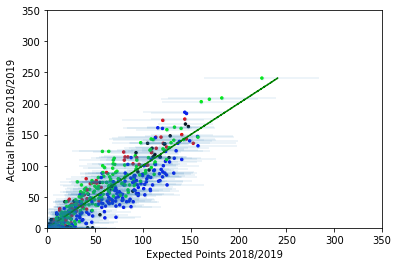

In [66]:
# plot with respect to last seasons points - for those players eligible
y3 = pd.read_csv("../data/players_raw_20182019.csv")
y3['full_name'] = (y3['first_name'] + ' ' + y3['second_name'])
exp_points = np.zeros(len(y3.index))
sd_points = np.zeros(len(y3.index))
cr = np.zeros((len(y3.index), 3))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    exp_points[i] = C[ind]
    sd_points[i] = S[ind]
    cr[i, :] = np.array([((all_players_params.loc[all_players_params.index[ind], 'position'] == 'FWD')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'MID')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'DEF'))])

plot.errorbar(exp_points, y3['total_points'] - y3['bonus'], xerr=2 * sd_points, marker='.', linestyle="", alpha=0.1)
plot.scatter(exp_points, y3['total_points'] - y3['bonus'], color=cr, s=6)
plot.plot(y3['total_points'] - y3['bonus'], y3['total_points'] - y3['bonus'], linestyle="--", color='g')
plot.xlim([0, 350])
plot.ylim([0, 350])
plot.xlabel('Expected Points 2018/2019')
plot.ylabel('Actual Points 2018/2019')
plot.show()

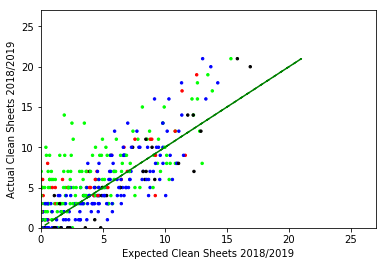

In [67]:
# plot with respect to last seasons clean sheets - for eligble players
clean_sheets = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    clean_sheets[i] = CS[ind]

plot.scatter(clean_sheets, y3['clean_sheets'], color=cr, s=6)
plot.plot(y3['clean_sheets'], y3['clean_sheets'], linestyle="--", color='g')
plot.xlim([0, 27])
plot.ylim([0, 27])
plot.xlabel('Expected Clean Sheets 2018/2019')
plot.ylabel('Actual Clean Sheets 2018/2019')
plot.show()

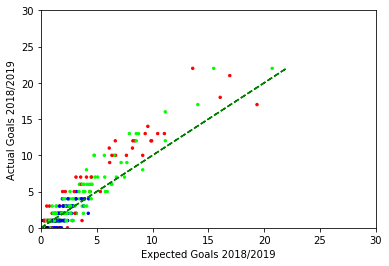

In [68]:
# plot with respect to last seasons goals - for eligble players
goals = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    goals[i] = G[ind]

plot.scatter(goals, y3['goals_scored'], color=cr, s=6)
plot.plot(y3['goals_scored'], y3['goals_scored'], linestyle="--", color='g')
plot.xlim([0, 30])
plot.ylim([0, 30])
plot.xlabel('Expected Goals 2018/2019')
plot.ylabel('Actual Goals 2018/2019')
plot.show()

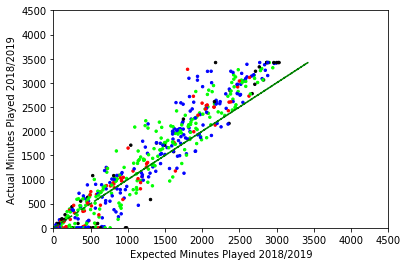

In [69]:
# plot with respect to last seasons mins played - for eligble players
mins_played = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    mins_played[i] = MP[ind]

plot.scatter(mins_played, y3['minutes'], s=6, color=cr)
plot.plot(y3['minutes'], y3['minutes'], linestyle="--", color='g')
plot.xlim([0, 4500])
plot.ylim([0, 4500])
plot.xlabel('Expected Minutes Played 2018/2019')
plot.ylabel('Actual Minutes Played 2018/2019')
plot.show()

### Team predictions

Gives predictions for a team's score on a gameweek

In [58]:
# this gameweek fixtures
#fixture_list_this_gw = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_gw)

# this gameweek form for each fixture
#form =...

# players for a specific team
tm_players = ['Mohamed Salah', 'James Milner'] #....
new_players_frame = all_players_params[all_players_params['player'].isin(tm_players)]
Niter = 100
C, S = ComputeExpectedPoints(fixture_list_this_gw, teams, new_players_frame, all_teams_params,
                             zerooutbottom=3, Niter=Niter, form=form)  # zero out bench players
expected_tm_score = np.sum(C)
sd_tm_score = np.sqrt(np.sum(S ** 2))
print('expected team score: ', expected_tm_score)
print('lower 95% confidence team score: ', max(0, expected_tm_score - (2 * sd_tm_score)))
print('upper 95% confidence team score: ', expected_tm_score + (2 * sd_tm_score))

---
Realisation  0
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 2.]  points
---
Realisation  1
Top Points Scorers:  310    Mohamed Salah
298     James Milner
Name: player, dtype: object  with  [2. 5.]  points
---
Realisation  2
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  3
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [ 4. 10.]  points
---
Realisation  4
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [2. 3.]  points
---
Realisation  5
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 3.]  points
---
Realisation  6
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  7
Top Points Scorers:  298     James Milner
310   

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
# calculates match probability
def match_prob(exp_p1, sd_p1, exp_p2, sd_p2):
    exp_diff = exp_p1 - exp_p2
    sd_diff = np.sqrt((sd_p1 ** 2) + (sd_p2 ** 2))
    return(1 - norm.cdf(0, exp_diff, sd_diff))